## Causal Inference

Computing the prompt engineering effect on ChatGPT Levenshtein performance

In [1]:
from Levenshtein import distance as lev
import pandas as pd


In [2]:
import json
json_path = '/workspaces/chat-gpt-failures/datasets/galeras_prompting/code_completion_docstring_3k_T2_deduped_tuned.json'
with open(json_path) as json_file:
    json_data = json.load(json_file)

In [4]:
lev_calc = [lev(x["code"].strip(), x["control"]["predicted"]["prediction"] ) for x in json_data]
result=[]
for i,data in enumerate(json_data):
    dataset = {}
    dataset["y_levenshtein"] = lev_calc[i]
    dataset["t_binary_treatment"] = False
    dataset["t_treatment"] = "control"
    dataset["z_prompt_size"] = data["control"]["prompt"]["p_n_words"]
    columns={'n_ast_errors':'z_n_ast_errors','ast_levels':'z_ast_levels','n_whitespaces':'z_n_whitespaces','complexity':'z_complexity','nloc':'z_nloc','token_counts':'z_token_counts','n_ast_nodes':'z_n_ast_nodes'}
    for col in columns:
        dataset[columns[col]] = data[col]
    result.append(dataset)

In [5]:
len(result)

2923

In [6]:
lev_calc_T1 = [lev(x["code"].strip(), x["T1"]["predicted"]["prediction"] ) for x in json_data]
for i,data in enumerate(json_data):
    dataset = {}
    dataset["y_levenshtein"] = lev_calc_T1[i]
    dataset["t_binary_treatment"] = True
    dataset["t_treatment"] = "T1"
    dataset["z_prompt_size"] = data["control"]["prompt"]["p_n_words"]
    columns={'n_ast_errors':'z_n_ast_errors','ast_levels':'z_ast_levels','n_whitespaces':'z_n_whitespaces','complexity':'z_complexity','nloc':'z_nloc','token_counts':'z_token_counts','n_ast_nodes':'z_n_ast_nodes'}
    for col in columns:
        dataset[columns[col]] = data[col]
    result.append(dataset)

In [7]:
lev_calc_T2 = [lev(x["code"].strip(), x["T2"]["predicted"]["prediction"] ) for x in json_data]
for i,data in enumerate(json_data):
    dataset = {}
    dataset["y_levenshtein"] = lev_calc_T2[i]
    dataset["t_binary_treatment"] = True
    dataset["t_treatment"] = "T2"
    dataset["z_prompt_size"] = data["control"]["prompt"]["p_n_words"]
    columns={'n_ast_errors':'z_n_ast_errors','ast_levels':'z_ast_levels','n_whitespaces':'z_n_whitespaces','complexity':'z_complexity','nloc':'z_nloc','token_counts':'z_token_counts','n_ast_nodes':'z_n_ast_nodes'}
    for col in columns:
        dataset[columns[col]] = data[col]
    result.append(dataset)

In [8]:
assert len(json_data)*3 == len(result)

In [9]:
df = pd.DataFrame(result)


In [10]:
df.head()

,y_levenshtein,t_binary_treatment,t_treatment,z_prompt_size,z_n_ast_errors,z_ast_levels,z_n_whitespaces,z_complexity,z_nloc,z_token_counts,z_n_ast_nodes
0,364,False,control,16,0,9,101,1,12,48,71
1,926,False,control,175,0,17,417,13,100,240,375
2,771,False,control,9,0,13,208,3,17,153,253
3,835,False,control,50,0,12,154,1,14,137,249
4,302,False,control,38,0,13,127,3,21,82,137


# Analysis

In [11]:
df[['y_levenshtein','t_binary_treatment']].groupby('t_binary_treatment').describe()

y_levenshtein                                             \
                           count        mean         std  min    25%    50%   
t_binary_treatment                                                            
False                     2923.0  591.967157  574.681982  0.0  243.0  464.0   
True                      5846.0  596.626753  579.245153  0.0  272.0  456.0   

                                    
                      75%      max  
t_binary_treatment                  
False               767.5  10913.0  
True                740.0  12311.0

In [12]:
df[['z_prompt_size','t_binary_treatment']].groupby('t_binary_treatment').describe()

z_prompt_size                                               \
                           count       mean        std  min   25%   50%   75%   
t_binary_treatment                                                              
False                     2923.0  38.900103  42.694812  7.0  15.0  25.0  45.0   
True                      5846.0  38.900103  42.691160  7.0  15.0  25.0  45.0   

                           
                      max  
t_binary_treatment         
False               622.0  
True                622.0

In [ ]:
#df_prune = df_total.drop(columns=['repo', 'path','file_name','fun_name','commit_message','code','random_split','tested_class','docstring','predicted_control', 'predicted_P2', 'language', 'url','signature', 'ast_errors' ])

In [ ]:
#df_prune = df_prune.rename(columns={'n_ast_errors':'z_n_ast_errors','ast_levels':'z_ast_levels','n_whitespaces_':'z_n_whitespaces','complexity':'z_complexity','nloc':'z_nloc','token_counts':'z_token_counts','n_ast_nodes':'z_n_ast_nodes'})

In [13]:
df.to_json('/workspaces/chat-gpt-failures/data/causal_prompting_pd_T2.json')

In [14]:
import seaborn as sns
sns.set_theme(style="darkgrid")

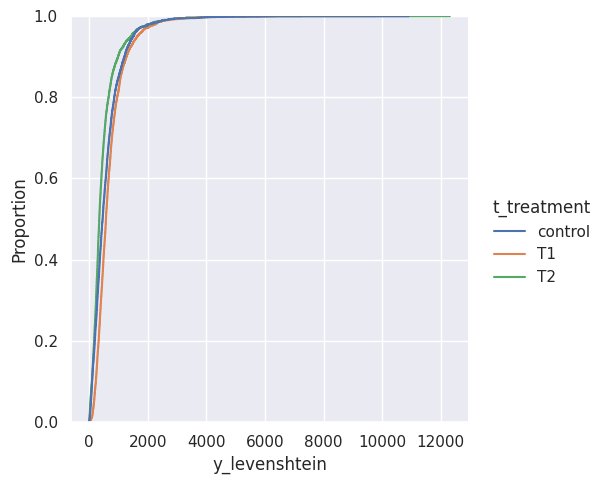

In [15]:
sns.displot(df, x="y_levenshtein", hue="t_treatment",kind="ecdf")

In [ ]:
#sns.histplot(data=df_prune[["words0","words1"]], kde=True, log_scale=True).set_title("test")

In [ ]:
df.head()

In [ ]:
df[['y_levenshtein','t_treatment']].boxplot( by='t_treatment',
    bootstrap=500, 
    showfliers=False,
    showmeans=True, 
    meanline = True,
    widths = 0.7
    )

In [24]:
from scipy import stats


In [26]:
confounders = {'z_prompt_size':'z_prompt_size', 'n_ast_errors':'z_n_ast_errors','ast_levels':'z_ast_levels','n_whitespaces_':'z_n_whitespaces','complexity':'z_complexity','nloc':'z_nloc','token_counts':'z_token_counts','n_ast_nodes':'z_n_ast_nodes'}

In [27]:
list(confounders.values())

['z_prompt_size',
 'z_n_ast_errors',
 'z_ast_levels',
 'z_n_whitespaces',
 'z_complexity',
 'z_nloc',
 'z_token_counts',
 'z_n_ast_nodes']

In [17]:
confounders =["z_prompt_size"]

In [40]:
df["y_levenshtein"][df["t_treatment"]=="control"].values

array([364, 926, 771, ...,   5, 602, 830])

In [43]:
treatments = ["control","T1", "T2"]

## Confounder pearson correlation: confounder -> Outcome

In [46]:

for z in list(confounders.values()):
    for treatment in treatments:
        tmp= stats.pearsonr(df["y_levenshtein"][df["t_treatment"]==treatment].values,df[z][df["t_treatment"]==treatment].values)
        print(z,treatment,tmp)
    

z_prompt_size control PearsonRResult(statistic=0.45213475318096796, pvalue=2.8669085429887753e-147)
z_prompt_size T1 PearsonRResult(statistic=0.40962831764103347, pvalue=1.1275180252031109e-118)
z_prompt_size T2 PearsonRResult(statistic=0.45348151123477415, pvalue=3.0408405060906894e-148)
z_n_ast_errors control PearsonRResult(statistic=0.02823704215456119, pvalue=0.12693997446276087)
z_n_ast_errors T1 PearsonRResult(statistic=0.05766157513068593, pvalue=0.0018163747370276689)
z_n_ast_errors T2 PearsonRResult(statistic=-0.018502691667671788, pvalue=0.3173097315289549)
z_ast_levels control PearsonRResult(statistic=0.40246794466657043, pvalue=2.9945371889349826e-114)
z_ast_levels T1 PearsonRResult(statistic=0.31339551236337776, pvalue=1.2543065468726542e-67)
z_ast_levels T2 PearsonRResult(statistic=0.44024799048801805, pvalue=7.415352190803907e-139)
z_n_whitespaces control PearsonRResult(statistic=0.6905482533040953, pvalue=0.0)
z_n_whitespaces T1 PearsonRResult(statistic=0.62592657526010

<Axes: xlabel='z_prompt_size', ylabel='y_levenshtein'>

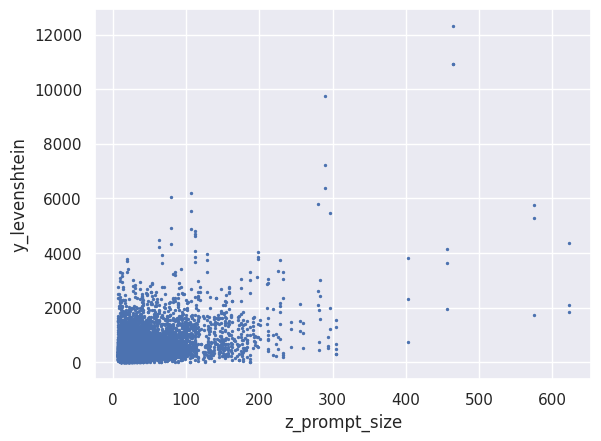

In [29]:
df.plot.scatter(x="z_prompt_size", y="y_levenshtein", s=2)

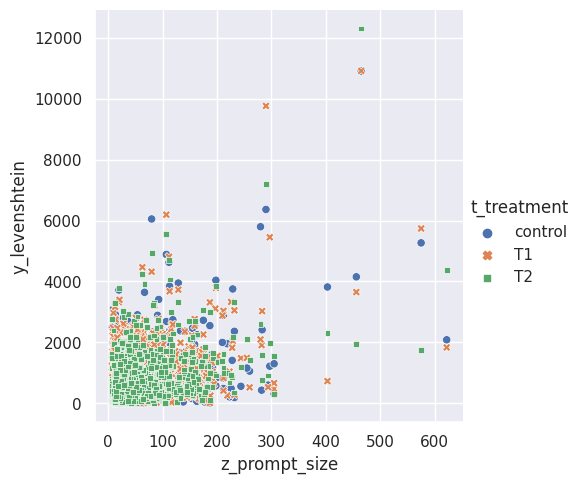

In [30]:
sns.relplot(
    data=df,
    x="z_prompt_size", y="y_levenshtein", hue="t_treatment", style="t_treatment"
)

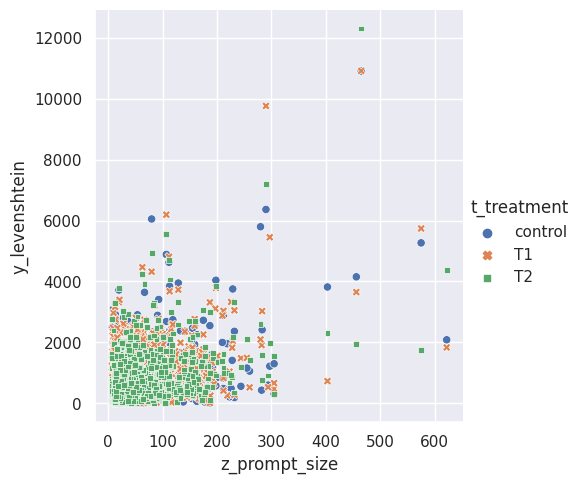

In [31]:
sns.relplot(
    data=df,
    x="z_prompt_size", y="y_levenshtein", hue="t_treatment", style="t_treatment"
)

/opt/conda/lib/python3.11/site-packages/seaborn/_stats/counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
/opt/conda/lib/python3.11/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)


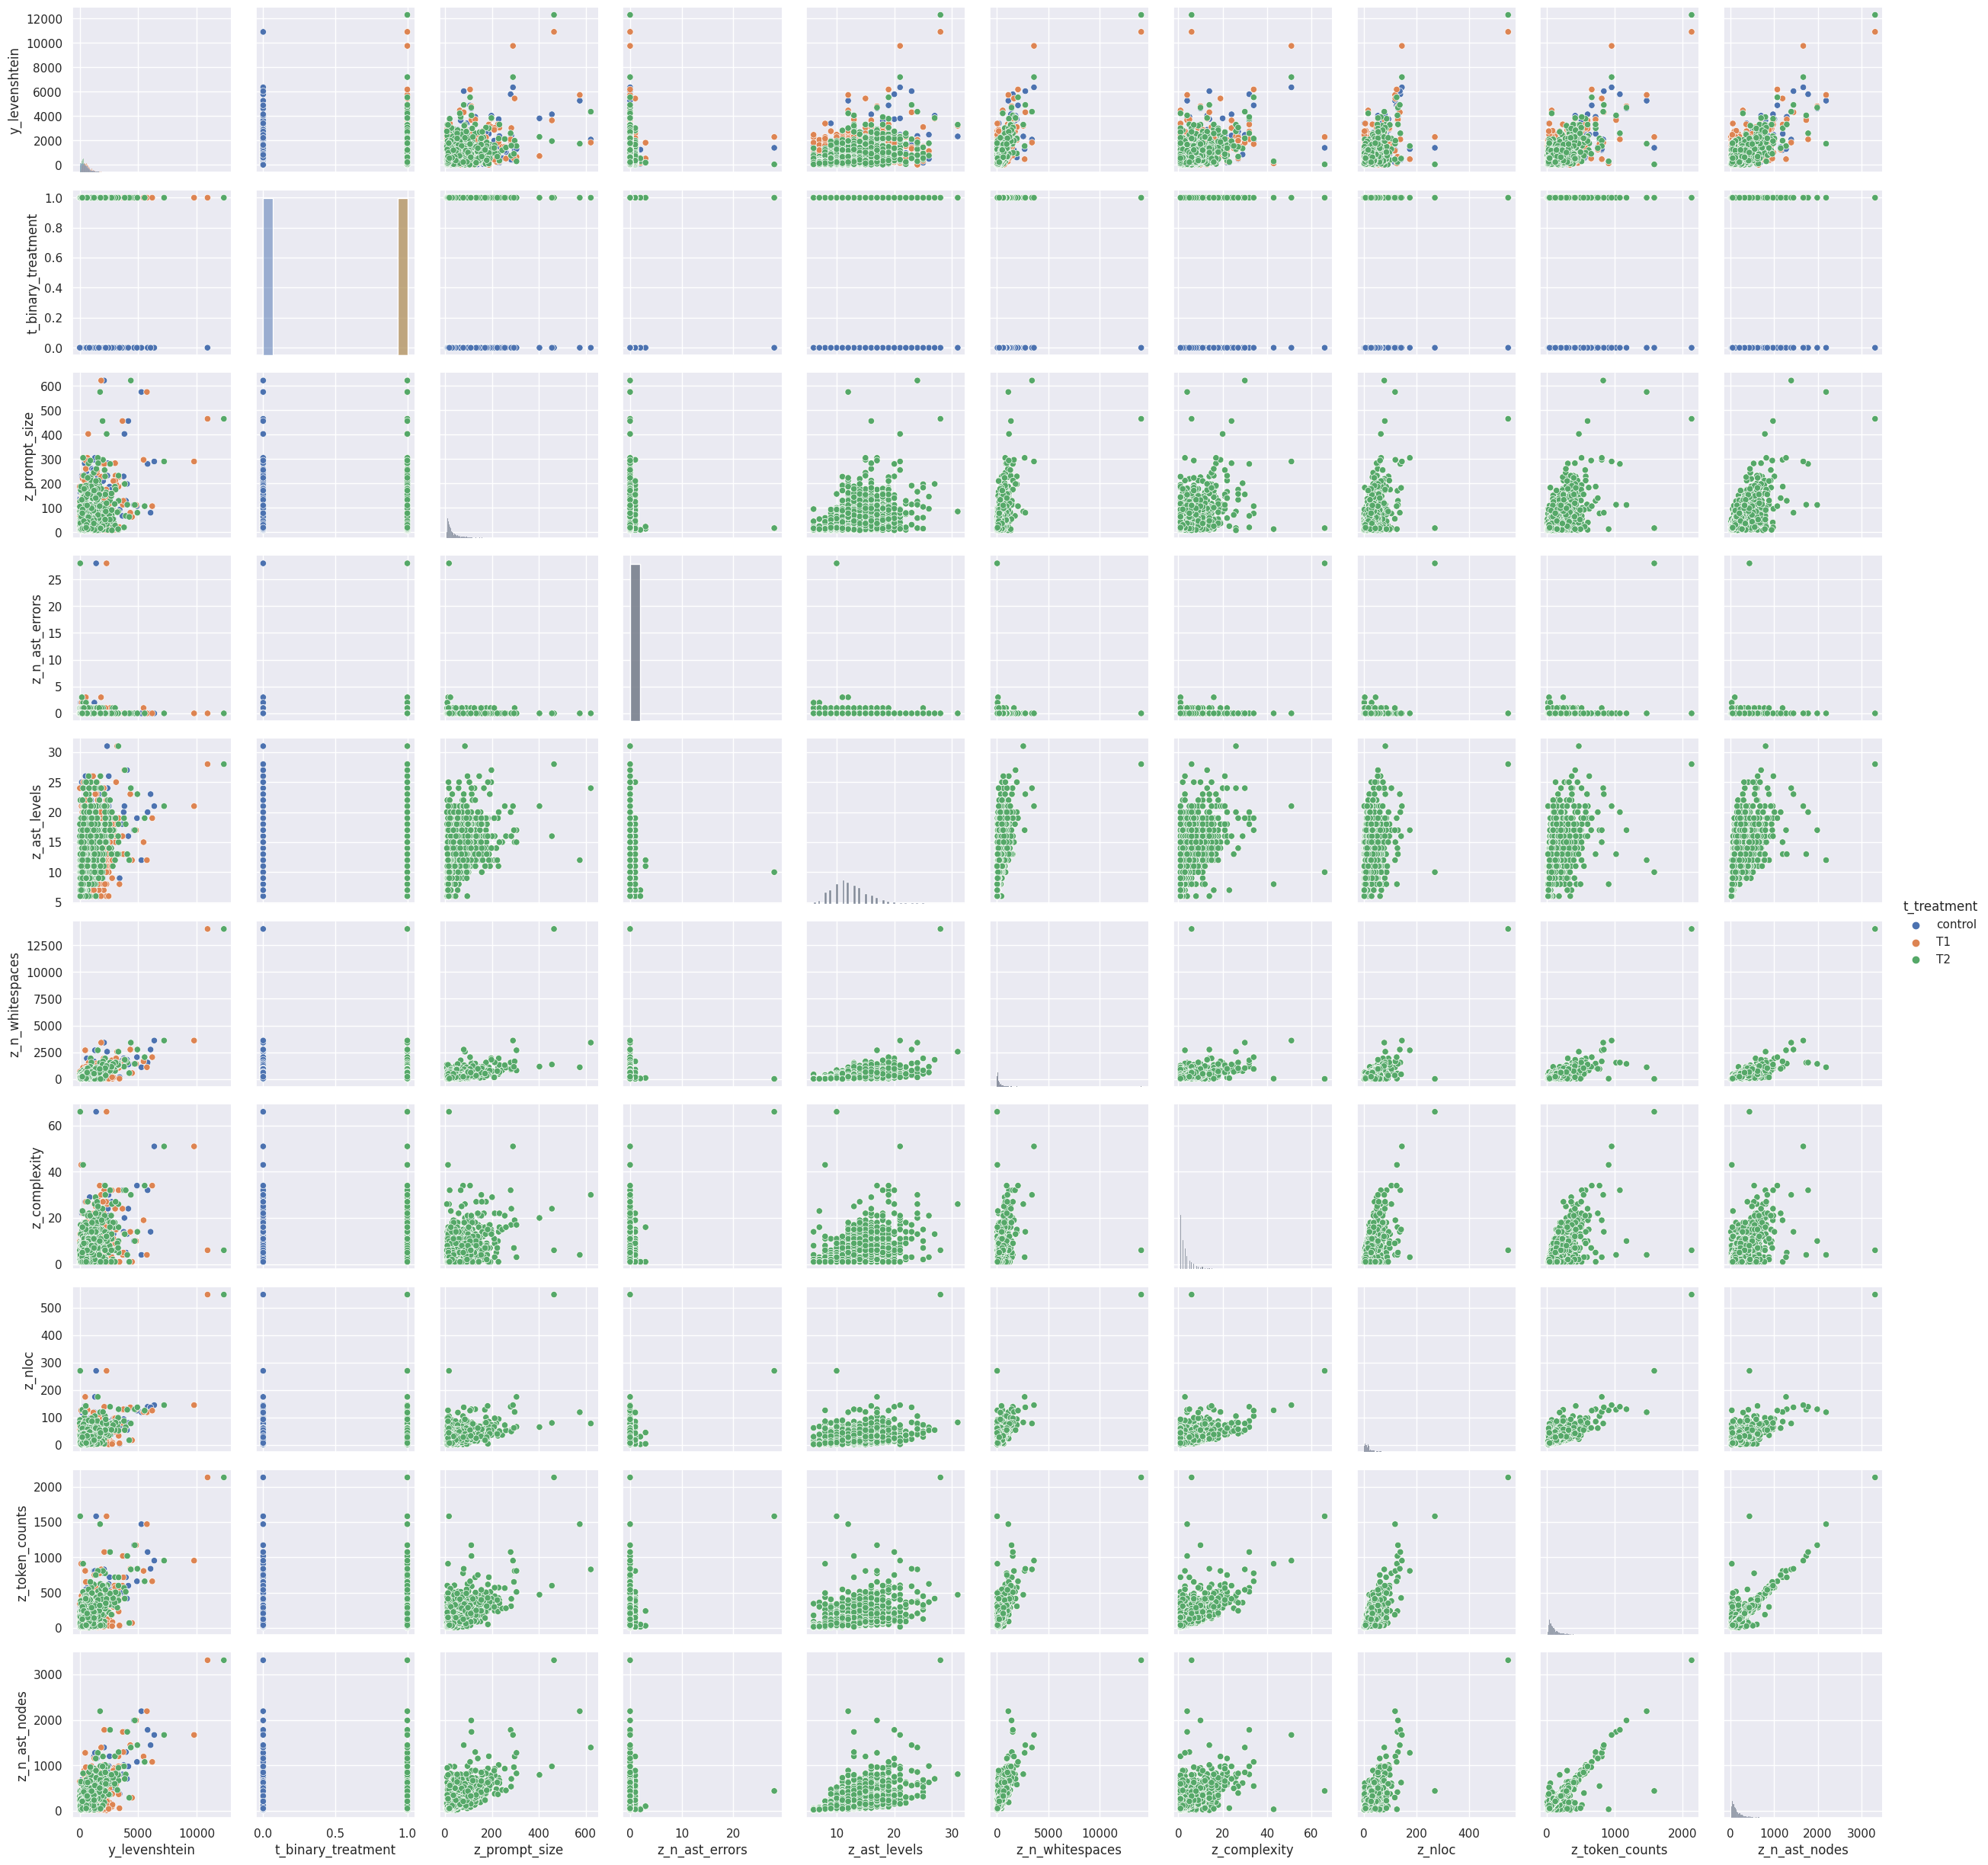

In [32]:
g = sns.PairGrid(df, hue="t_treatment")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
